Задания, модуль по NLP:

**Задание 1:**

В папке с данными (data) расположен датасет bbc , который содержит 5 классов новостных статей (business, entertainment, politics, sport, tech). Вам необходимо реализовать следующее:

1. Обучить любой (на ваш выбор) алгоритм классификации из классических алгоритмов машинного обучения (не нейронная сеть!) и измерить метрику качества работы модели (не забываем также проверять качество на инференсе).
2. Дообучить модель DistillBert для многоклассовой классификации и проверить также качество работы алгоритма (н забываем проверять качество на инференсе). Похожий код был продемонстрирован на лекции, думаем головой, не копипастите, есть нюансы в данной задаче.
3. Оформить оба решения в пайплайны. Отдаем новости – получаем метку класса и вероятность. Соскрапить или собрать вручную по пять свежих новостей с ресурса (https://www.bbc.com/news - ссылки на новости прикрепить в ноутбуке) для каждого из классов и прогнать на них пайплайны.  Получить результаты инференса пайплайнов, и оценить какое из решений лучше.


**Задание 2:**

По каждому из классов (business, entertainment, politics, sport, tech) вам необходимо взять каждый класс и смоделировать распределение топиков (тем) по каждому из классов и построить визуализации. Необходимо объяснить о чем больше всего говорится в каждом из классов, то есть сделать на основании вашей работы анализ по каждому из классов. Используем любой подход, который вам известен для задачи Topic Modelling. 


**Рекомендации по выполнению домашнего задания:**

1. Можете выполнять его в Jupyter Notebook (2 задание обязательно в Jupyter Notebook так как это будет ваш аналитический отчет). 
2. Для тех, у кого недостаточно ресурсов, можете выполнить работу в Google Collab. 
3. Для формирования датасета, рекомендую пользоваться модулем datasets, который мы изучили на лекции. 
4. По поводу представления корпуса данных, выбираем любой удобный вам способ, который как вы считаете лучше всего решит вам задачу.

Реализовываем весь пайплайн от загрузки, очистки и NLP пайплайна до подачи данных в датасет, весь тот процесс который был продемонстрирован в первых лекциях.

# Задание 1:

В папке с данными (data) расположен датасет bbc , который содержит 5 классов новостных статей (business, entertainment, politics, sport, tech). Вам необходимо реализовать следующее:

Обучить любой (на ваш выбор) алгоритм классификации из классических алгоритмов машинного обучения (не нейронная сеть!) и измерить метрику качества работы модели (не забываем также проверять качество на инференсе).
Дообучить модель DistillBert для многоклассовой классификации и проверить также качество работы алгоритма (н забываем проверять качество на инференсе). Похожий код был продемонстрирован на лекции, думаем головой, не копипастите, есть нюансы в данной задаче.
Оформить оба решения в пайплайны. Отдаем новости – получаем метку класса и вероятность. Соскрапить или собрать вручную по пять свежих новостей с ресурса (https://www.bbc.com/news - ссылки на новости прикрепить в ноутбуке) для каждого из классов и прогнать на них пайплайны. Получить результаты инференса пайплайнов, и оценить какое из решений лучше.

## Чтение текстовых документов и делаем предобработку данных

In [1]:
import pandas as pd
import os
import warnings
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import re
import nltk
from nltk.corpus import stopwords

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')     # Для токенизации
nltk.download('wordnet')   # Для лемматизации
nltk.download('stopwords') # Загрузка стоп-слов

class BBC_Dataset:
    def __init__(self, data_dir="bbc/"):
        """
        параметр data_dir - указывает на директорию, где находятся текстовые файлы.
        
        """
        # Сохраняем путь к директории с данными
        self.data_dir = data_dir
        # Создаем список полных путей к файлам в указанной директории и всех ее поддиректориях
        self.doc = [
            os.path.join(path, name)
            for path, _, files in os.walk(self.data_dir)
            for name in files
        ]
        """
        Инициализация лемматизатора и стоп-слов
        
        """
        self.lemmatizer = WordNetLemmatizer()
        
        self.stop_words = stopwords.words('english')   # Получаем стандартные стоп-слова и преобразуем в список
        # Добавляем недостающие слова
        additional_stop_words = ['ha', 'wa', 'could', 'id', 'ill', 'im', 'ive', 'might', 'must', 'bn', 
                                 'need', 'shall', 'shouldve', 'werent', 'would', 'yukos', 'v', 'lse',
                                 'eu', 'us', 'uk', 'mr', 'russian', 'england', 'ireland', 'zealand']
        # Используем extend для добавления слов в список
        self.stop_words.extend(additional_stop_words)

        # Словарь, который заменяет сокращения на полные формы в тексте
        self.contractions = {
            "aren't": "are not",
            "couldn't": "could not",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'll": "he will",
            "he's": "he is",
            "I'd": "I would",
            "I'll": "I will",
            "I'm": "I am",
            "isn't": "is not",
            "it'd": "it would",
            "it'll": "it will",
            "it's": "it is",
            "I've": "I have",
            "mightn't": "might not",
            "mustn't": "must not",
            "needn't": "need not",
            "shan't": "shall not",
            "she'd": "she would",
            "she'll": "she will",
            "she's": "she is",
            "shouldn't": "should not",
            "that'll": "that will",
            "they'd": "they would",
            "they'll": "they will",
            "they're": "they are",
            "they've": "they have",
            "wasn't": "was not",
            "we'd": "we would",
            "we'll": "we will",
            "we're": "we are",
            "we've": "we have",
            "won't": "will not",
            "wouldn't": "would not",
            "you'd": "you would",
            "you'll": "you will",
            "you're": "you are",
            "you've": "you have",
        }
        
        """
        Инициализация векторизатора

        """
        self.vectorizer = TfidfVectorizer(
            stop_words=self.stop_words,    # Используем обновленный список стоп-слов
            norm="l1",
            preprocessor=self.preprocess_text,
        )
        # Получение DataFrame
        self.dataframe = self.get_pandas_alike_dataset()

    """
    Метод, для замены сокращенных форм слов на их полные формы в переданном тексте

    """
    def expand_contractions(self, text):
        """
        параметр text - текс с обработанной формой слов.
        
        """
        for contraction, full_form in self.contractions.items():
            text = re.sub(r'\b' + re.escape(contraction) + r'\b', full_form, text)
        return text

    """
    Метод, для обработки текста, подготавливая его для анализа
    
    """
    def preprocess_text(self, text: str) -> str:
        text = self.expand_contractions(text)         # Заменяем сокращения на полные формы
        text = re.sub(r"[^a-z\s]", "", text.lower())  # Удаляем все символы, кроме строчных английских букв и пробелов
        tokens = word_tokenize(text)                  # Токенизация
    
        # Лемматизация и удаление стоп-слов
        #tokens = [self.lemmatizer.lemmatize(word) 
        #          for word in tokens if word not in self.stop_words and len(word) > 1]

        # Лемматизация и удаление стоп-слов
        tokens = [
            self.lemmatizer.lemmatize(word)
            for word in tokens 
            if word not in self.stop_words]

        # tokens = [word for word in tokens if len(word) > 1]

        return " ".join(tokens)  # Возвращаем текст, состоящий из оставшихся токенов
        

    def get_dataset(self):
        """
        Загружает текстовые документы и их категории.
    
        """
        data = []
        for file in self.doc:
            # Определяет категорию на основе имени родительской директории
            label = os.path.basename(os.path.dirname(file))
            try:
                # Открывает файл, читает его содержимое и добавляет кортеж (content, label) в список data.
                with open(file, "r", encoding="latin-1") as f:
                    content = f.read().strip()
                # Обрабатываем текст перед добавлением в список
                processed_content = self.preprocess_text(content)
                data.append((processed_content, label))
            except Exception as e:
                # Если возникает ошибка при чтении файла, она обрабатывается и выводится сообщение
                print(f"Ошибка чтения файла {file}: {e}")
        return data

    """
    Метод, который возвращает DataFrame с текстами и метками.
        
    """
    def get_pandas_alike_dataset(self):
        data = self.get_dataset()
        return pd.DataFrame(data, columns=["text", "label"])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Разделение данных

Считаем и загрузим наши данные в переменную data.

In [2]:
# Загрузка данных
bbc_dataset = BBC_Dataset(data_dir="bbc/")
data = bbc_dataset.dataframe

# Вывод результата и информации о датафрейме (data)
print(data)
print()
print(data.info())

                                                   text     label
0     ad sale boost time warner profit quarterly pro...  business
1     dollar gain greenspan speech dollar hit highes...  business
2     unit buyer face loan claim owner embattled oil...  business
3     high fuel price hit ba profit british airway b...  business
4     pernod takeover talk lift domecq share drink f...  business
...                                                 ...       ...
2216  bt program beat dialler scam bt introducing tw...      tech
2217  spam email tempt net shopper computer user acr...      tech
2218  careful code new european directive put softwa...      tech
2219  cyber security chief resigns man making sure c...      tech
2220  losing online gaming online role playing game ...      tech

[2221 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0  

In [3]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Векторизация текста

In [4]:
X_train_vector = bbc_dataset.vectorizer.fit_transform(X_train)
X_val_vector = bbc_dataset.vectorizer.transform(X_val)
X_test_vector = bbc_dataset.vectorizer.transform(X_test)

## Обучение модели
Для обучения в качестве классического алгоритма машинного обучения выберем GradientBoosting.

In [5]:
# Импорт библиотек
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Инициализация и обучение модели
gb = GradientBoostingClassifier(n_estimators=500, max_depth=5, learning_rate=0.1, random_state=42)
gb.fit(X_train_vector, y_train)

# Предсказание на валидационной выборке
y_val_pred = gb.predict(X_val_vector)

# Оценка качества модели
print("Validation Accuracy (GradientBoostingClassifier):", accuracy_score(y_val, y_val_pred))
print()
print(classification_report(y_val, y_val_pred))

# Предсказание на тестовой выборке
y_test_pred = gb.predict(X_test_vector)

# Оценка качества модели на тестовой выборке
print("Test Accuracy (GradientBoostingClassifier):", accuracy_score(y_test, y_test_pred))
print()
print(classification_report(y_test, y_test_pred))

Validation Accuracy (GradientBoostingClassifier): 0.963963963963964

               precision    recall  f1-score   support

     business       0.98      1.00      0.99        54
entertainment       0.97      0.94      0.95        33
     politics       1.00      0.91      0.95        43
        sport       0.94      1.00      0.97        49
         tech       0.93      0.95      0.94        43

     accuracy                           0.96       222
    macro avg       0.96      0.96      0.96       222
 weighted avg       0.96      0.96      0.96       222

Test Accuracy (GradientBoostingClassifier): 0.9551569506726457

               precision    recall  f1-score   support

     business       0.95      0.95      0.95        56
entertainment       0.95      0.95      0.95        37
     politics       0.95      0.92      0.94        39
        sport       0.98      1.00      0.99        45
         tech       0.96      0.96      0.96        46

     accuracy                        

## Обучение модели DistilBERT
Для обучения модели DistilBERT нужно будет использовать библиотеку transformers от Hugging Face

In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

"""
Загрузим предобученные версии токенизатора и модели DistilBERT, 
которые будут использоваться для классификации последовательностей на 5 категорий.

"""
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

"""
Преобразуем данные X_train, X_val и X_test в формат, который понимает модель DistilBERT. 
Каждое текстовое сообщение токенизируется, обрезается и заполняется до нужной длины.

"""
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Преобразование в PyTorch Dataset
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Преобразование меток в числовой формат
label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}
y_train_numeric = [label_mapping[label] for label in y_train]
y_val_numeric = [label_mapping[label] for label in y_val]
y_test_numeric = [label_mapping[label] for label in y_test]

# Создание датасетов
train_dataset = NewsDataset(train_encodings, y_train_numeric)
val_dataset = NewsDataset(val_encodings, y_val_numeric)
test_dataset = NewsDataset(test_encodings, y_test_numeric)

# Определение аргументов для обучения
training_args = TrainingArguments(
    output_dir='./results',          # выходная директория
    num_train_epochs=6,              # количество эпох
    per_device_train_batch_size=9,   # размер батча для обучения
    per_device_eval_batch_size=9,    # размер батча для оценки
    warmup_steps=500,                # количество шагов разогрева
    weight_decay=0.1,                # коэффициент регуляризации
    logging_dir='./logs',            # директория для логов
    logging_steps=150,
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Добавим функцию для определения метрик
def compute_metrics(p):
    """
    параметр p - это объект, который содержит предсказания модели и истинные метки
    
    """
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Создание тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics # вывод метрик
)

# Обучение модели
trainer.train()

# Оценка модели на валидационной выборке
val_results = trainer.evaluate(val_dataset)
print("Validation Results (DistilBERT):", val_results)
print()

# Оценка модели на тестовой выборке
test_results = trainer.evaluate(test_dataset)
print("Test Results (DistilBERT):", test_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Results (DistilBERT): {'eval_loss': 0.08800443261861801, 'eval_accuracy': 0.9819819819819819, 'eval_f1': 0.9818988471287912, 'eval_precision': 0.9820246017526817, 'eval_recall': 0.9819819819819819, 'eval_runtime': 61.6845, 'eval_samples_per_second': 3.599, 'eval_steps_per_second': 0.405, 'epoch': 6.0}

Test Results (DistilBERT): {'eval_loss': 0.297023743391037, 'eval_accuracy': 0.9506726457399103, 'eval_f1': 0.9507679988470943, 'eval_precision': 0.9509588779696594, 'eval_recall': 0.9506726457399103, 'eval_runtime': 85.017, 'eval_samples_per_second': 2.623, 'eval_steps_per_second': 0.294, 'epoch': 6.0}


## Прогоним через пайплайны и сравнение результатов
Для проверки качества предсказания классов возьмем по 5 статей с сайта https://www.bbc.com/news, для каждого из класса (business, entertainment, politics, sport, tech). Статьи брались по следющим ссылкам:

Статьи на business:

1. https://www.bbc.com/news/articles/c0mw1yw3kyvo
2. https://www.bbc.com/news/articles/c0eggy1104po
3. https://www.bbc.com/news/articles/ce8yy3wpn6eo
4. https://www.bbc.com/news/articles/cn527pz54neo
5. https://www.bbc.com/news/articles/c05ml3q2gn7o

Статьи на entertainment:

1. https://www.bbc.com/news/articles/c4g007jjlyqo
2. https://www.bbc.com/culture/article/20250224-10-of-the-best-tv-shows-to-watch-this-march
3. https://www.bbc.com/culture/article/20250225-amy-heckerling-on-how-clueless-revolutionised-the-high-school-comedy
4. https://www.bbc.com/news/articles/clye46n565xo
5. https://www.bbc.com/travel/article/20250220-koh-mak-the-tiny-island-thats-redefining-travel-to-thailand

Статьи на politics:

1. https://www.bbc.com/news/articles/cvgddp56570o
2. https://www.bbc.com/news/articles/c2erwgwy8vgo
3. https://www.bbc.com/news/articles/cz9n5jq42pdo
4. https://www.bbc.com/news/live/c625ex282zzt
5. https://www.bbc.com/news/articles/czjeejw9z4zo

Статьи на sport:

1. https://www.bbc.com/sport/formula1/articles/czedde0p0pzo
2. https://www.bbc.com/sport/cricket/articles/c5ymg8py7r0o
3. https://www.bbc.com/sport/cycling/articles/c4gpp2xl9w7o
4. https://www.bbc.com/sport/golf/articles/cn0440k0747o
5. https://www.bbc.com/sport/tennis/articles/cy5nk1101zgo

Статьи на tech:

1. https://www.bbc.com/future/article/20250117-planetary-parade-what-the-alignment-of-seven-planets-really-means-for-science
2. https://www.bbc.com/news/articles/c5y0r8wdk62o
3. https://www.bbc.com/news/articles/cn7vxlrvxyeo
4. https://www.bbc.com/news/articles/cy877gydn48o
5. https://www.bbc.com/future/article/20250224-what-happens-when-you-give-an-ai-a-rorschach-inkblot-test

Сохранили данные статьи в блокноты и далее мы их считаем при помощи нашего класса BBC_Dataset:

In [7]:
# Загрузка данных
new_bbc = BBC_Dataset(data_dir="newbbc")
new_articles = new_bbc.dataframe['text']
print(new_articles)
print()
print(new_articles.info())

0     bp shareholder want make money climate policy ...
1     head european commission ursula von der leyen ...
2     trump say impose additional tariff china donal...
3     ukraine president volodymyr zelensky met presi...
4     president donald trump said planning hit good ...
5     biggest night british music upon brit award ge...
6     lavish historical epic set sicily satire holly...
7     proud wonderful teen amy heckerling clueless r...
8     glimpse picasso pollock masterpiece kept tehra...
9     season three white lotus drawing fresh wave vi...
10    meltdown horror show pileon however want descr...
11    ukraine president hoping leave white house fri...
12    european leader rallied behind volodymyr zelen...
13    world leader begin react white house meeting w...
14    donald trump appears confidence capability bri...
15    twentyfour hour formula preseason testing thre...
16    end came quicker anyone expected six month ago...
17    tom pidcock said goodbye ineos grenadier t

In [8]:
# Инференс через классическую модель
new_articles_vectorized = bbc_dataset.vectorizer.transform(new_articles)

# Предсказание классов
predictions_classical = gb.predict(new_articles_vectorized)

# Вывод результатов
print("Классический алгоритм:")
for article, label in zip(new_articles, predictions_classical):
    print(f"Статья: {article[:40]}\nПредсказанный класс: {label}\n")

Классический алгоритм:
Статья: bp shareholder want make money climate p
Предсказанный класс: business

Статья: head european commission ursula von der 
Предсказанный класс: business

Статья: trump say impose additional tariff china
Предсказанный класс: business

Статья: ukraine president volodymyr zelensky met
Предсказанный класс: business

Статья: president donald trump said planning hit
Предсказанный класс: business

Статья: biggest night british music upon brit aw
Предсказанный класс: entertainment

Статья: lavish historical epic set sicily satire
Предсказанный класс: entertainment

Статья: proud wonderful teen amy heckerling clue
Предсказанный класс: entertainment

Статья: glimpse picasso pollock masterpiece kept
Предсказанный класс: entertainment

Статья: season three white lotus drawing fresh w
Предсказанный класс: entertainment

Статья: meltdown horror show pileon however want
Предсказанный класс: politics

Статья: ukraine president hoping leave white hou
Предсказанный класс: po

In [9]:
# Инференс через модель DistilBERT
new_encodings = tokenizer(list(new_articles), truncation=True, padding=True, return_tensors='pt')

# Предсказание классов
with torch.no_grad():
    outputs = model(**new_encodings)
    predictions_distilbert = torch.argmax(outputs.logits, dim=1).numpy()

# Преобразование предсказаний в метки
predicted_labels_distilbert = [list(label_mapping.keys())[pred] for pred in predictions_distilbert]

# Вывод результатов
print("DistilBERT:")
for article, label in zip(new_articles, predicted_labels_distilbert):
    print(f"Статья: {article[:40]}\nПредсказанный класс: {label}\n")

DistilBERT:
Статья: bp shareholder want make money climate p
Предсказанный класс: business

Статья: head european commission ursula von der 
Предсказанный класс: business

Статья: trump say impose additional tariff china
Предсказанный класс: business

Статья: ukraine president volodymyr zelensky met
Предсказанный класс: business

Статья: president donald trump said planning hit
Предсказанный класс: business

Статья: biggest night british music upon brit aw
Предсказанный класс: entertainment

Статья: lavish historical epic set sicily satire
Предсказанный класс: entertainment

Статья: proud wonderful teen amy heckerling clue
Предсказанный класс: entertainment

Статья: glimpse picasso pollock masterpiece kept
Предсказанный класс: entertainment

Статья: season three white lotus drawing fresh w
Предсказанный класс: business

Статья: meltdown horror show pileon however want
Предсказанный класс: politics

Статья: ukraine president hoping leave white hou
Предсказанный класс: politics

Статья: 

## Результаты по предсказанным данным:
Было подоброно по 5 статей, для каждого класса (business, entertainment, politics, sport, tech), расположенные по порядку. В результате предсказаний в качестве классической модели был выбран GradientBoosting, который успешно предсказал все классы. DistilBERT не смог предсказать один результат. Однако долго производился перебор гипперпараметров и само обучение. В результате из-за куда дольшего времени обучения нейронной сети (DistilBERT), классическая модель (GradientBoosting) остается более предпочтительнее в данном случае. 

Результаты предсказания приведены в таблице:

| №    | Загаданные статьи (классы) | Предсказанные классы (GradientBoosting) | Предсказанные классы (DistilBERT) |
|------|-------------------|-----------------------------------------|-----------------------------------|
| 1 |  business | business   | business |
| 2  |  business | business      | business |
| 3  |  business | business   | business |
| 4  |  business | business      | business |
| 5  |  business | business   | business |
|    |           |            |             |
| 1  |  entertainment | entertainment      | entertainment |
| 2  |  entertainment | entertainment   | entertainment |
| 3  |  entertainment | entertainment      | entertainment |
| 4  |  entertainment | entertainment   | entertainment |
| 5  |  entertainment | entertainment      | **business** |
|    |           |            |             |
| 1  |  politics | politics   | politics |
| 2  |  politics | politics      | politics |
| 3  |  politics | politics   | politics |
| 4  |  politics | politics      | politics |
| 5  |  politics | politics   | politics |
|    |           |            |             |
| 1  |  sport | sport      | sport |
| 2  |  sport | sport   | sport |
| 3  |  sport | sport      | sport |
| 4  |  sport | sport   | sport |
| 5  |  sport | sport      | sport |
|    |           |            |             |
| 1  |  tech | tech   | tech |
| 2  |  tech | tech      | tech |
| 3  |  tech | tech   | tech |
| 4  |  tech | tech      | tech |
| 5  |  tech | tech   | tech |


# Задание 2:

По каждому из классов (business, entertainment, politics, sport, tech) вам необходимо взять каждый класс и смоделировать распределение топиков (тем) по каждому из классов и построить визуализации. Необходимо объяснить о чем больше всего говорится в каждом из классов, то есть сделать на основании вашей работы анализ по каждому из классов. Используем любой подход, который вам известен для задачи Topic Modelling.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


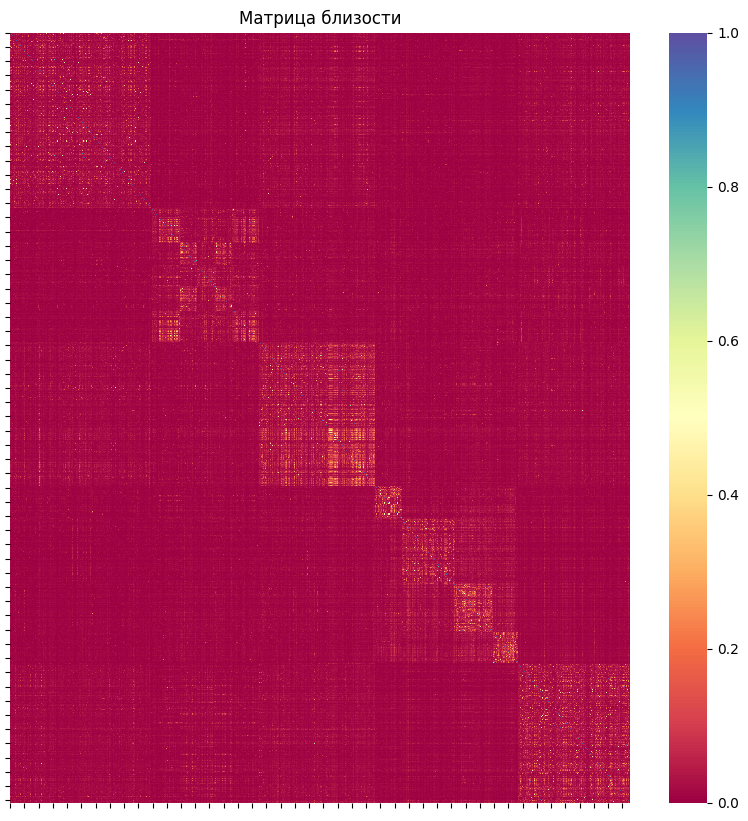

In [10]:
# Импорт необходимых библиотек
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import TfidfModel
from gensim import similarities

# Загрузка необходимых ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')  # Загрузка токенизатора

# Создание экземпляра класса BBC_Dataset
bbc_dataset = BBC_Dataset(data_dir="bbc/")
data = bbc_dataset.dataframe  # Получаем DataFrame с текстами и метками

# Подготовка текстов для Gensim
texts = [data.text.iloc[i].split() for i in range(len(data))]

# Создание словаря и корпуса
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Создание модели TF-IDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Создание индекса для вычисления сходства
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

# Визуализация матрицы сходства
plt.figure(figsize=(10, 10))
sns.heatmap(data=sims, cmap='Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

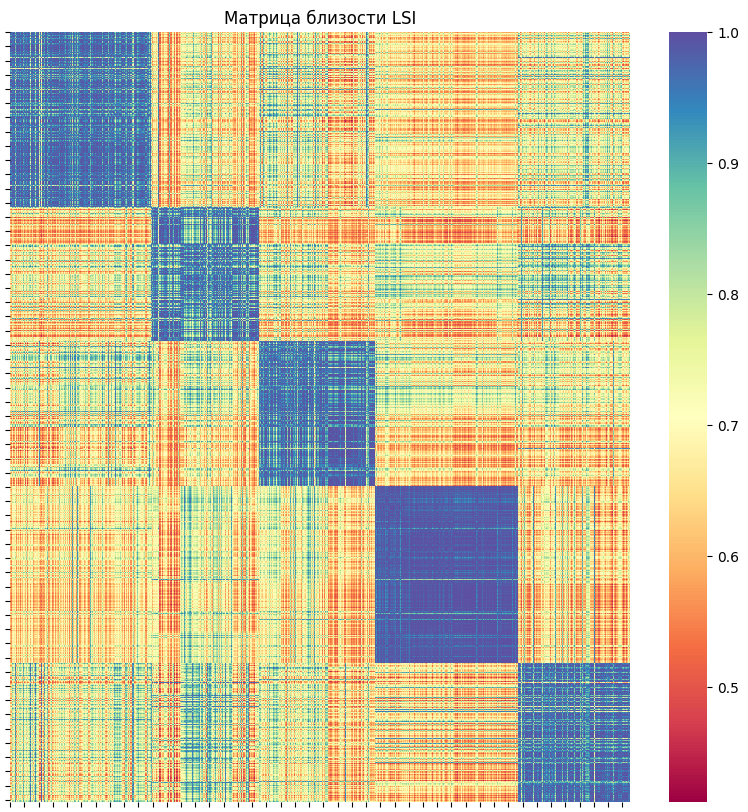

In [11]:
# Создание LSI модели
lsi = models.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

# Преобразование корпуса в LSI пространство
corpus_lsi = lsi[corpus_tfidf]  # Каждый документ будет представлен в виде вектора, который характеризует его составность по темам.

# Создание индекса для вычисления сходства
index = similarities.MatrixSimilarity(corpus_lsi)  # Индекс для вычисления сходства между всеми документами в пространстве тем.
sims = index[corpus_lsi]
sims = (sims + 1) / 2.  # Нормализация значений

# Визуализация матрицы близости
plt.figure(figsize=(10, 10))
sns.heatmap(data=sims, cmap='Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости LSI")
plt.show()

In [12]:
# Подготовка данных для каждого класса
texts_by_class = {label: data[data['label'] == label]['text'].tolist() for label in data['label'].unique()}

# Моделирование LSI для каждого класса
lsi_models = {}

for label, texts in texts_by_class.items():
    # Используем уже обработанные тексты
    tokenized_texts = [text.split() for text in texts]  # Разделяем текст на слова

    # Создание частотного словаря
    frequency = defaultdict(int)
    for text in tokenized_texts:
        for token in text:
            frequency[token] += 1

    # Удаление слов, которые встречаются только один раз
    filtered_texts = [[token for token in text if frequency[token] > 1] for text in tokenized_texts]
    
    # Создание словаря и корпуса
    dictionary = corpora.Dictionary(filtered_texts)
    corpus = [dictionary.doc2bow(text) for text in filtered_texts if text]
    
    # Обучение LSI модели
    lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=5)
    lsi_models[label] = lsi_model

# Вывод тем и слов для каждого класса
for label, model in lsi_models.items():
    print(f"LSI темы для класса: {label}")
    topics = model.print_topics(num_words=5)  # Извлечение 5 наиболее значимых слов для каждой темы
    for topic in topics:
        print(topic)
    print("\n")

LSI темы для класса: business
(0, '0.510*"said" + 0.267*"year" + 0.164*"company" + 0.155*"market" + 0.148*"firm"')
(1, '0.298*"company" + 0.283*"firm" + -0.272*"rate" + -0.261*"economy" + -0.249*"growth"')
(2, '0.370*"sale" + -0.266*"country" + 0.260*"price" + -0.224*"government" + -0.215*"economic"')
(3, '0.314*"oil" + 0.276*"sale" + -0.221*"glazer" + -0.195*"club" + -0.183*"bid"')
(4, '-0.498*"bank" + 0.237*"sale" + 0.226*"year" + -0.185*"oil" + -0.171*"rate"')


LSI темы для класса: entertainment
(0, '0.397*"best" + 0.335*"song" + 0.314*"music" + 0.263*"year" + 0.231*"award"')
(1, '-0.546*"film" + 0.372*"music" + 0.255*"song" + -0.210*"said" + 0.194*"urban"')
(2, '-0.476*"music" + 0.406*"song" + -0.340*"urban" + 0.327*"best" + -0.174*"black"')
(3, '0.325*"best" + -0.268*"said" + -0.244*"show" + 0.227*"urban" + 0.210*"award"')
(4, '0.466*"film" + -0.335*"best" + -0.243*"award" + 0.243*"song" + -0.152*"album"')


LSI темы для класса: politics
(0, '0.516*"said" + 0.214*"government" + 0

Рассмотрим как каждая тема отражает определённый аспект класса (Business, Entertainment, Politics и т.д.), для LSI. Веса слов показывают, насколько сильно каждое слово связано с темой. Отрицательные веса указывают на противопоставление или критику.

1. Класс: Business (Бизнес)

Основные темы:
- Обсуждение компаний и рынков: В текстах часто упоминаются компании, фирмы и их деятельность на рынке. Ключевые слова: company, firm, market.
- Экономические показатели: Обсуждаются темы, связанные с экономическим ростом, ставками и банковской деятельностью. Ключевые слова: economy, growth, rate, bank.
- Продажи и цены: Важное место занимают обсуждения продаж, цен и их влияния на бизнес. Ключевые слова: sale, price.
- Нефтяная промышленность: Часто упоминается нефть и её роль в экономике. Ключевые слова: oil, bid.
- Государственное влияние: Рассматривается роль правительства в экономике и бизнесе. Ключевые слова: government, economic.

Общий вывод: Класс business охватывает широкий спектр экономической деятельности, включая компании, рынки, финансы, продажи и государственное регулирование.

2. Класс: Entertainment (Развлечения)

Основные темы:
- Музыка и награды: В текстах часто обсуждаются музыкальные награды, популярные песни и альбомы. Ключевые слова: music, song, award, best.
- Киноиндустрия: Значительное внимание уделяется фильмам и кинематографу. Ключевые слова: film, show.
- Жанры музыки: Обсуждаются различные музыкальные жанры, такие как urban. Ключевые слова: urban, black.
- Шоу-бизнес: Тексты часто касаются популярных шоу и артистов. Ключевые слова: show, album.

Общий вывод: Класс entertainment сосредоточен на музыке, фильмах, наградах и шоу-бизнесе, отражая ключевые аспекты индустрии развлечений.

3. Класс: Politics (Политика)

Основные темы:
- Политические партии: В текстах обсуждаются партии и их деятельность. Ключевые слова: party, labour, government.
- Экономическая политика: Рассматриваются темы, связанные с заработной платой, налогами и экономическим ростом. Ключевые слова: wage, minimum, increase, business.
- Выборы и лидеры: Часто упоминаются выборы и политические лидеры. Ключевые слова: election, brown, blair.
- Терроризм и безопасность: Обсуждаются вопросы терроризма и национальной безопасности. Ключевые слова: terrorist.

Общий вывод: Класс politics охватывает политические партии, выборы, экономическую политику и лидеров, а также вопросы безопасности.

4. Класс: Sport (Спорт)

Основные темы:
- Спортивные события: В текстах часто обсуждаются игры, победы и игроки. Ключевые слова: game, win, player.
- Теннис: Значительное внимание уделяется теннисным матчам и игрокам. Ключевые слова: roddick, nadal, point.
- Футбол: Обсуждаются футбольные клубы и игроки. Ключевые слова: liverpool, gerrard, club.
- Регби и другие виды спорта: Рассматриваются темы, связанные с регби и мировыми спортивными событиями. Ключевые слова: rugby, world.

Общий вывод: Класс sport охватывает футбол, теннис, регби и другие виды спорта, а также мировые спортивные события.

5. Класс: Tech (Технологии)

Основные темы:
- Мобильные технологии: В текстах часто обсуждаются мобильные телефоны и гаджеты. Ключевые слова: mobile, phone, gadget.
- Игровая индустрия: Значительное внимание уделяется играм и игровым устройствам. Ключевые слова: game, gaming.
- Цифровые технологии: Рассматриваются цифровые услуги и технологии. Ключевые слова: digital, technology, broadband.
- Интернет и услуги: Обсуждаются темы, связанные с интернетом и онлайн-сервисами. Ключевые слова: site, service.

Общий вывод: Класс tech охватывает мобильные технологии, игры, цифровые услуги и интернет, отражая ключевые аспекты технологической индустрии.

In [13]:
import gensim

# Разделение данных по классам
class_data = {label: data[data['label'] == label]['text'].tolist() for label in data['label'].unique()}

# Моделирование тем для каждого класса
lda_models = {}

for label, texts in class_data.items():
    tokenized_texts = [text.split() for text in texts]  # Разделяем текст на слова
    
    # Создание частотного словаря
    frequency = defaultdict(int)
    for text in tokenized_texts:
        for token in text:
            frequency[token] += 1

    # Удаление слов, которые встречаются только один раз
    filtered_texts = [[token for token in text if frequency[token] > 1] for text in tokenized_texts]
    
    # Создание словаря и корпуса
    dictionary = corpora.Dictionary(filtered_texts)
    corpus = [dictionary.doc2bow(text) for text in filtered_texts if text]
    
    # Обучение LDA модели
    lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
    lda_models[label] = (lda_model, dictionary, corpus)

# Извлечение тем и слов
for label, (model, dictionary, corpus) in lda_models.items():
    print(f"LDA Темы для класса: {label}")
    topics = model.print_topics(num_words=5)  # Извлечение 5 наиболее значимых слов для каждой темы
    for topic in topics:
        print(topic)
    print("\n")

LDA Темы для класса: business
(0, '0.017*"said" + 0.011*"year" + 0.008*"country" + 0.006*"profit" + 0.006*"market"')
(1, '0.018*"said" + 0.008*"year" + 0.007*"new" + 0.006*"firm" + 0.005*"bank"')
(2, '0.017*"said" + 0.014*"company" + 0.011*"firm" + 0.009*"share" + 0.006*"year"')
(3, '0.016*"said" + 0.012*"company" + 0.011*"oil" + 0.010*"firm" + 0.008*"tax"')
(4, '0.019*"said" + 0.013*"year" + 0.012*"rate" + 0.011*"growth" + 0.011*"price"')


LDA Темы для класса: entertainment
(0, '0.012*"show" + 0.010*"year" + 0.010*"music" + 0.009*"said" + 0.007*"film"')
(1, '0.014*"said" + 0.009*"music" + 0.008*"year" + 0.008*"show" + 0.006*"people"')
(2, '0.032*"film" + 0.022*"best" + 0.019*"award" + 0.010*"actor" + 0.010*"said"')
(3, '0.015*"said" + 0.010*"music" + 0.008*"chart" + 0.007*"year" + 0.007*"single"')
(4, '0.011*"film" + 0.010*"number" + 0.009*"year" + 0.008*"band" + 0.008*"one"')


LDA Темы для класса: politics
(0, '0.023*"said" + 0.009*"law" + 0.009*"party" + 0.007*"government" + 0.007

Рассмотрим как каждая тема отражает определённый аспект класса (Business, Entertainment, Politics и т.д.), для LDA:

1. Класс: Business (Бизнес)

Основные темы:
- Обсуждение компаний и рынков: В текстах часто упоминаются компании, фирмы и их деятельность на рынке. Ключевые слова: company, firm, market, share.
- Экономические показатели: Обсуждаются темы, связанные с прибылью, налогами и экономическим ростом. Ключевые слова: profit, tax, growth, rate.
- Финансовые учреждения: Рассматриваются темы, связанные с банками и финансовыми услугами. Ключевые слова: bank, price.
- Нефтяная промышленность: Часто упоминается нефть и её роль в экономике. Ключевые слова: oil.

Общий вывод: Класс business охватывает широкий спектр экономической деятельности, включая компании, рынки, финансы, налоги и нефтяную промышленность.

2. Класс: Entertainment (Развлечения)

Основные темы:
- Музыка и награды: В текстах часто обсуждаются музыкальные награды, популярные песни и альбомы. Ключевые слова: music, award, single, chart.
- Киноиндустрия: Значительное внимание уделяется фильмам, актёрам и наградам. Ключевые слова: film, actor, best.
- Шоу-бизнес: Тексты часто касаются популярных шоу и музыкальных групп. Ключевые слова: show, band, number.
- Музыкальные чарты: Обсуждаются музыкальные чарты и популярные синглы. Ключевые слова: chart, single.

Общий вывод: Класс entertainment сосредоточен на музыке, фильмах, наградах и шоу-бизнесе, отражая ключевые аспекты индустрии развлечений.

3. Класс: Politics (Политика)

Основные темы:
- Политические партии: В текстах обсуждаются партии и их деятельность. Ключевые слова: party, labour, tory, election.
- Политические лидеры: Часто упоминаются политические лидеры, такие как Браун и Блэр. Ключевые слова: brown, blair.
- Правительство и налоги: Рассматриваются темы, связанные с правительством и налоговой политикой. Ключевые слова: government, tax, minister.
- Выборы и законы: Обсуждаются выборы и законодательные вопросы. Ключевые слова: election, law, right.

Общий вывод: Класс politics охватывает политические партии, выборы, лидеров, правительство и налоговую политику.

4. Класс: Sport (Спорт)

Основные темы:
- Спортивные события: В текстах часто обсуждаются игры, победы и игроки. Ключевые слова: game, win, player, cup.
- Футбольные клубы: Значительное внимание уделяется футбольным клубам, таким как "Челси" и "Ливерпуль". Ключевые слова: club, chelsea, liverpool.
- Голы и матчи: Обсуждаются голы и ключевые моменты матчей. Ключевые слова: goal, minute.
- Регби и международные соревнования: Рассматриваются темы, связанные с регби и международными соревнованиями. Ключевые слова: wale, nation, six.

Общий вывод: Класс sport охватывает футбол, регби, спортивные события и международные соревнования.

5. Класс: Tech (Технологии)

Основные темы:
- Мобильные технологии: В текстах часто обсуждаются мобильные телефоны и технологии. Ключевые слова: mobile, phone, technology.
- Интернет и сайты: Значительное внимание уделяется интернету и онлайн-сервисам. Ключевые слова: internet, site, net, search.
- Игры и гаджеты: Обсуждаются игры и технологические устройства. Ключевые слова: game, gadget, gaming.
- Пользователи и блоги: Рассматриваются темы, связанные с пользователями и блогами. Ключевые слова: user, blog, people.

Общий вывод: Класс tech охватывает мобильные технологии, интернет, игры, гаджеты и онлайн-сервисы.

In [14]:
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import plotly.offline as py
import plotly.graph_objs as go

# Визуализация для каждой LDA модели с помощью pyLDAvis
for label, (lda_model, dictionary, corpus) in lda_models.items():
    vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.display(vis_data)

# Визуализация различий между темами с помощью plotly
py.init_notebook_mode()        # Активирует режим отображения графиков в Jupyter Notebook.

# Визуализируем различия между темами с помощью тепловой карты (Heatmap).
def plot_difference(mdiff, title="", annotation=None):
    """
    Вспомогательная функция для разницы в сюжете между моделями
    
    """
    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=500, height=500, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

# Визуализация различий между темами для каждой LDA модели
for label, (lda_model, dictionary, corpus) in lda_models.items():
    print(f"Различия между темами для класса: {label}")
    mdiff, annotation = lda_model.diff(lda_model, distance='jaccard', num_words=50)       # Сравнивает темы внутри одной модели LDA
    plot_difference(mdiff, title=f"Topic difference for class {label} [jaccard distance]", annotation=annotation)

Различия между темами для класса: business


Различия между темами для класса: entertainment


Различия между темами для класса: politics


Различия между темами для класса: sport


Различия между темами для класса: tech
